# mRNA Design Model Comparison Analysis

This notebook analyzes the comparison tables from conditional vs unconditional mRNA design models, focusing on sequence quality metrics, diversity, and performance characteristics.

## Overview
- **Conditional Model**: Uses additional conditioning information
- **Unconditional Model**: Standard generation without conditioning
- **Metrics Analyzed**: GC content, MFE energy, CAI scores, rewards, edit distances, identity percentages


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

base_path = Path("/home/ubuntu/aya/GFN_for_mRNA_design/outputs/conditional_unconditional_comparison_2025-09-15_09-55")
conditional_path = base_path / "conditional_short_seen"
unconditional_path = base_path / "unconditional_short_seen"

path1 = '/home/ubuntu/aya/GFN_for_mRNA_design/outputs/conditional/small/Conditional_Small_Sequence_32AA_2025-09-15_15-27/comprehensive_comparison_2025-09-15_15-27.txt'
path2 = '/home/ubuntu/aya/GFN_for_mRNA_design/outputs/curriculum_evaluation/short_seen_2025-09-15_18-56/comprehensive_comparison_2025-09-15_18-56.txt'

path1_metrics = '/home/ubuntu/aya/GFN_for_mRNA_design/outputs/conditional/small/Conditional_Small_Sequence_32AA_2025-09-15_15-27/metrics_summary_2025-09-15_15-27.txt'
path2_metrics = '/home/ubuntu/aya/GFN_for_mRNA_design/outputs/curriculum_evaluation/short_seen_2025-09-15_18-56/metrics_summary_2025-09-15_18-56.txt'


In [2]:
def parse_comparison_table(file_path):
    """
    Parse the comparison table from text file into a pandas DataFrame
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Find the table data lines (skip header and separator lines)
    data_lines = []
    in_table = False

    for line in lines:
        line = line.strip()
        # Look for lines that contain data (have | and contain Gen or Natural)
        if '|' in line and ('Gen' in line or 'Natural' in line):
            in_table = True
            data_lines.append(line)
        elif line.startswith('+') and in_table:
            # End of table
            break

    # Parse each data line
    data = []
    for line in data_lines:
        # Split by | and clean up
        parts = [part.strip() for part in line.split('|') if part.strip()]
        if len(parts) >= 8:  # Ensure we have all columns
            try:
                seq_name = parts[0]
                gc_percent = float(parts[1])
                mfe = float(parts[2])
                cai = float(parts[3])
                reward = float(parts[4]) if parts[4] != 'N/A' else np.nan
                levenshtein = int(parts[5])
                identity_percent = float(parts[6])
                length_diff = int(parts[7])

                if seq_name == 'Natural':
                    normalized_levenshtein = 0.0
                else:
                    length = 32
                    normalized_levenshtein = round((levenshtein / length) * 100, 2)

                data.append({
                    'Sequence': seq_name,
                    'GC_Percent': gc_percent,
                    'MFE': mfe,
                    'CAI': cai,
                    'Reward': reward,
                    'Levenshtein': normalized_levenshtein, # Gives the proportion of the edit distance to obtain the natural sequence
                    # 'Identity_Percent': identity_percent,
                    'Length_Diff': length_diff
                })
            except (ValueError, IndexError) as e:
                print(f"Error parsing line: {line}")
                print(f"Parts: {parts}")
                continue

    return pd.DataFrame(data)

def parse_metrics_summary(file_path):
    """
    Parse the metrics summary file into a dictionary
    """
    metrics = {}
    with open(file_path, 'r') as f:
        lines = f.readlines()

    in_table = False
    for line in lines:
        line = line.strip()
        if '|' in line and 'Metric' in line:
            in_table = True
            continue
        elif line.startswith('+') and in_table:
            break
        elif in_table and '|' in line and not line.startswith('|'):
            parts = [part.strip() for part in line.split('|') if part.strip()]
            if len(parts) >= 2:
                metric_name = parts[0]
                try:
                    value = float(parts[1])
                    metrics[metric_name] = value
                except ValueError:
                    metrics[metric_name] = parts[1]

    current_section = None
    for line in lines:
        line = line.strip()
        if 'Statistics:' in line:
            current_section = line.replace(' Statistics:', '').replace(':', '')
        elif current_section and ':' in line and not line.startswith('+'):
            try:
                key, value = line.split(':', 1)
                key = key.strip()
                value = float(value.strip())
                metrics[f"{current_section}_{key}"] = value
            except ValueError:
                continue

    return metrics

In [26]:
condi_small_df = parse_comparison_table(path1)
cl_small_df = parse_comparison_table(path2)
condi_small_metrics = parse_metrics_summary(path1_metrics)
cl_small_metrics = parse_metrics_summary(path2_metrics)

In [69]:
conditional_df = parse_comparison_table(conditional_path / "comprehensive_comparison_2025-09-15_11-21.txt")
conditional_metrics = parse_metrics_summary(conditional_path / "metrics_summary_2025-09-15_11-21.txt")

unconditional_df = parse_comparison_table(unconditional_path / "comprehensive_comparison_2025-09-15_11-12.txt")
unconditional_metrics = parse_metrics_summary(unconditional_path / "metrics_summary_2025-09-15_11-12.txt")

conditional_df['Model_Type'] = 'Conditional'
unconditional_df['Model_Type'] = 'Unconditional'

combined_df = pd.concat([conditional_df, unconditional_df], ignore_index=True)

print(f"Conditional model: {len(conditional_df)} sequences")
print(f"Unconditional model: {len(unconditional_df)} sequences")

Conditional model: 51 sequences
Unconditional model: 51 sequences


In [70]:
print("\n=== DISTRIBUTION SUMMARIES ===")
def distribution_summary(df, model_name, metrics=['GC_Percent', 'MFE', 'CAI', 'Normalized_Levenshtein']):
    """Calculate detailed distribution summaries"""
    print(f"\n{model_name} Model Distribution Summary:")
    print("-" * 50)

    for metric in metrics:
        if metric in df.columns:
            data = df[metric].dropna()
            if len(data) > 0:
                print(f"\n{metric}:")
                print(f"  Mean: {data.mean():.3f}")
                print(f"  Std:  {data.std():.3f}")
                print(f"  10th percentile: {np.percentile(data, 10):.3f}")
                print(f"  50th percentile: {np.percentile(data, 50):.3f}")
                print(f"  90th percentile: {np.percentile(data, 90):.3f}")
                print(f"  Min: {data.min():.3f}")
                print(f"  Max: {data.max():.3f}")


distribution_summary(conditional_df, "Conditional")
distribution_summary(unconditional_df, "Unconditional")


=== DISTRIBUTION SUMMARIES ===

Conditional Model Distribution Summary:
--------------------------------------------------

GC_Percent:
  Mean: 51.260
  Std:  1.939
  10th percentile: 49.490
  50th percentile: 51.520
  90th percentile: 53.540
  Min: 47.470
  Max: 56.570

MFE:
  Mean: -33.728
  Std:  3.064
  10th percentile: -37.700
  50th percentile: -32.970
  90th percentile: -30.770
  Min: -41.900
  Max: -26.800

CAI:
  Mean: 0.536
  Std:  0.054
  10th percentile: 0.470
  50th percentile: 0.540
  90th percentile: 0.610
  Min: 0.440
  Max: 0.640

Unconditional Model Distribution Summary:
--------------------------------------------------

GC_Percent:
  Mean: 50.685
  Std:  1.990
  10th percentile: 48.480
  50th percentile: 50.510
  90th percentile: 52.530
  Min: 46.460
  Max: 55.560

MFE:
  Mean: -32.220
  Std:  3.331
  10th percentile: -35.900
  50th percentile: -31.730
  90th percentile: -28.500
  Min: -44.000
  Max: -25.900

CAI:
  Mean: 0.529
  Std:  0.051
  10th percentile: 0.46

In [10]:
# Diversity Analysis - Normalized Levenshtein Distance
print("=== DIVERSITY ANALYSIS ===")
print("Analyzing sequence diversity using normalized Levenshtein distance...")

# Calculate diversity statistics
def diversity_analysis(df, model_name):
    """Analyze diversity metrics for a model"""
    norm_lev = df['Levenshtein'].dropna()
    lev = df['Levenshtein'].dropna()

    print(f"\n{model_name} Model Diversity:")
    print("-" * 40)
    print(f"Normalized Levenshtein Distance:")
    print(f"  Mean: {norm_lev.mean():.4f}")
    print(f"  Std:  {norm_lev.std():.4f}")
    print(f"  Min:  {norm_lev.min():.4f}")
    print(f"  Max:  {norm_lev.max():.4f}")
    print(f"  25th percentile: {np.percentile(norm_lev, 25):.4f}")
    print(f"  50th percentile: {np.percentile(norm_lev, 50):.4f}")
    print(f"  75th percentile: {np.percentile(norm_lev, 75):.4f}")

    print(f"\nRaw Levenshtein Distance:")
    print(f"  Mean: {lev.mean():.2f}")
    print(f"  Std:  {lev.std():.2f}")
    print(f"  Min:  {lev.min()}")
    print(f"  Max:  {lev.max()}")

    # Diversity interpretation
    mean_norm_lev = norm_lev.mean()
    if mean_norm_lev < 0.1:
        diversity_level = "Low"
    elif mean_norm_lev < 0.3:
        diversity_level = "Medium"
    else:
        diversity_level = "High"

    print(f"\nDiversity Level: {diversity_level} (mean normalized distance: {mean_norm_lev:.3f})")

    return {
        'mean_norm_lev': mean_norm_lev,
        'std_norm_lev': norm_lev.std(),
        'diversity_level': diversity_level
    }

=== DIVERSITY ANALYSIS ===
Analyzing sequence diversity using normalized Levenshtein distance...


In [14]:
# Set publication-quality plotting parameters
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Define publication color scheme
colors = {
    'conditional': '#2E86AB',  # Professional blue
    'unconditional': '#A23B72',  # Professional red
    'natural': '#F18F01'  # Professional orange
}

In [ ]:
# Analyze diversity for both models
cond_diversity = diversity_analysis(conditional_df, "Conditional")
uncond_diversity = diversity_analysis(unconditional_df, "Unconditional")

# Compare diversity between models
print(f"\n=== DIVERSITY COMPARISON ===")
print(f"Conditional model mean normalized distance: {cond_diversity['mean_norm_lev']:.4f}")
print(f"Unconditional model mean normalized distance: {uncond_diversity['mean_norm_lev']:.4f}")
print(f"Difference: {cond_diversity['mean_norm_lev'] - uncond_diversity['mean_norm_lev']:.4f}")

In [18]:
cl_small_df

,Sequence,GC_Percent,MFE,CAI,Reward,Levenshtein,Length_Diff
0,Gen 1,54.55,-37.10,0.58,0.76,68.75,0
1,Gen 2,54.55,-36.53,0.57,0.76,81.25,0
2,Gen 3,56.57,-32.50,0.58,0.74,71.88,0
3,Gen 4,53.54,-36.10,0.56,0.74,65.62,0
4,Gen 5,52.53,-31.10,0.65,0.72,78.12,0
5,Gen 6,50.51,-36.80,0.57,0.72,75.00,0
6,Gen 7,51.52,-36.10,0.53,0.71,75.00,0
7,Gen 8,52.53,-30.90,0.60,0.70,78.12,0
8,Gen 9,54.55,-34.20,0.47,0.69,81.25,0
9,Gen 10,53.54,-31.00,0.55,0.69,75.00,0


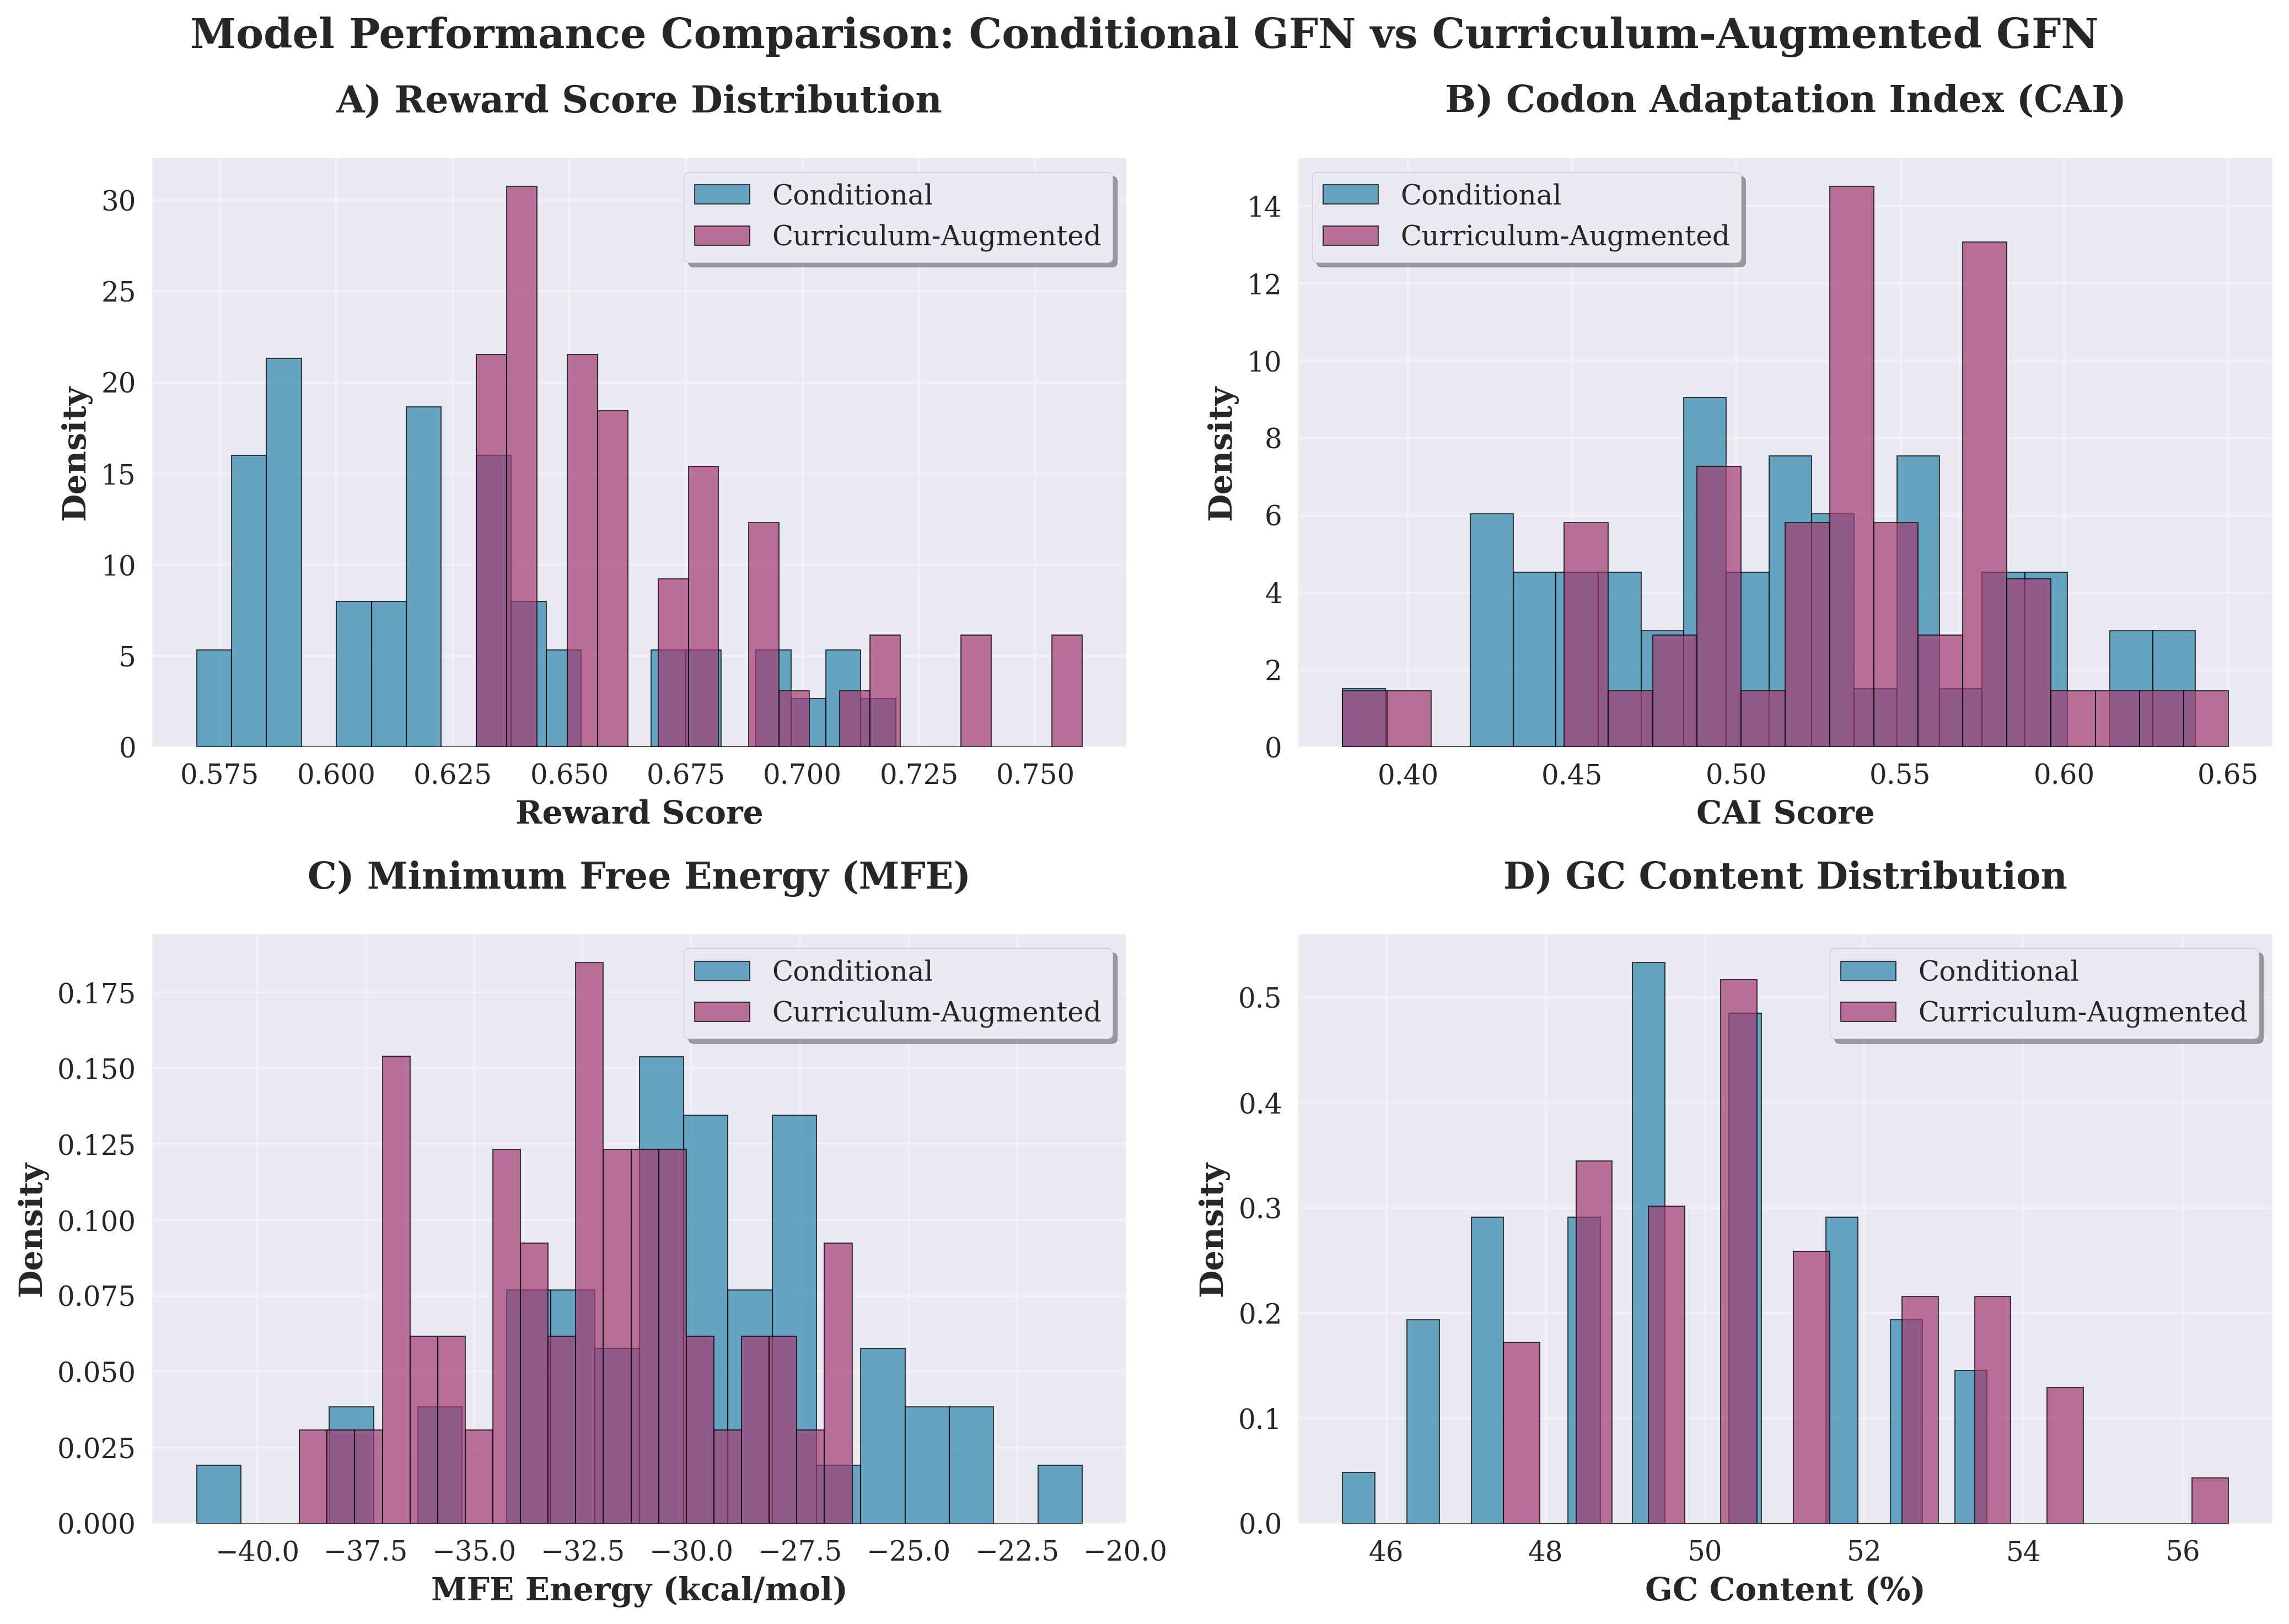

In [17]:
# Figure 1: Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison: Conditional GFN vs Curriculum-Augmented GFN', fontsize=18, fontweight='bold', y=0.98)

# A) Reward Score Distribution
ax1 = axes[0, 0]
ax1.hist(condi_small_df['Reward'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['conditional'], label='Conditional', edgecolor='black', linewidth=0.5)
ax1.hist(cl_small_df['Reward'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['unconditional'], label='Curriculum-Augmented', edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Reward Score', fontweight='bold')
ax1.set_ylabel('Density', fontweight='bold')
ax1.set_title('A) Reward Score Distribution', fontweight='bold', pad=20)
ax1.legend(frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3)

# B) CAI Score Distribution
ax2 = axes[0, 1]
ax2.hist(condi_small_df['CAI'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['conditional'], label='Conditional', edgecolor='black', linewidth=0.5)
ax2.hist(cl_small_df['CAI'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['unconditional'], label='Curriculum-Augmented', edgecolor='black', linewidth=0.5)
ax2.set_xlabel('CAI Score', fontweight='bold')
ax2.set_ylabel('Density', fontweight='bold')
ax2.set_title('B) Codon Adaptation Index (CAI)', fontweight='bold', pad=20)
ax2.legend(frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3)

# C) MFE Energy Distribution
ax3 = axes[1, 0]
ax3.hist(condi_small_df['MFE'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['conditional'], label='Conditional', edgecolor='black', linewidth=0.5)
ax3.hist(cl_small_df['MFE'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['unconditional'], label='Curriculum-Augmented', edgecolor='black', linewidth=0.5)
ax3.set_xlabel('MFE Energy (kcal/mol)', fontweight='bold')
ax3.set_ylabel('Density', fontweight='bold')
ax3.set_title('C) Minimum Free Energy (MFE)', fontweight='bold', pad=20)
ax3.legend(frameon=True, fancybox=True, shadow=True)
ax3.grid(True, alpha=0.3)

# D) GC Content Distribution
ax4 = axes[1, 1]
ax4.hist(condi_small_df['GC_Percent'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['conditional'], label='Conditional', edgecolor='black', linewidth=0.5)
ax4.hist(cl_small_df['GC_Percent'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['unconditional'], label='Curriculum-Augmented', edgecolor='black', linewidth=0.5)
ax4.set_xlabel('GC Content (%)', fontweight='bold')
ax4.set_ylabel('Density', fontweight='bold')
ax4.set_title('D) GC Content Distribution', fontweight='bold', pad=20)
ax4.legend(frameon=True, fancybox=True, shadow=True)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/ubuntu/aya/GFN_for_mRNA_design/Figure1_Model_Performance_Comparison_Condi_vs_CL.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


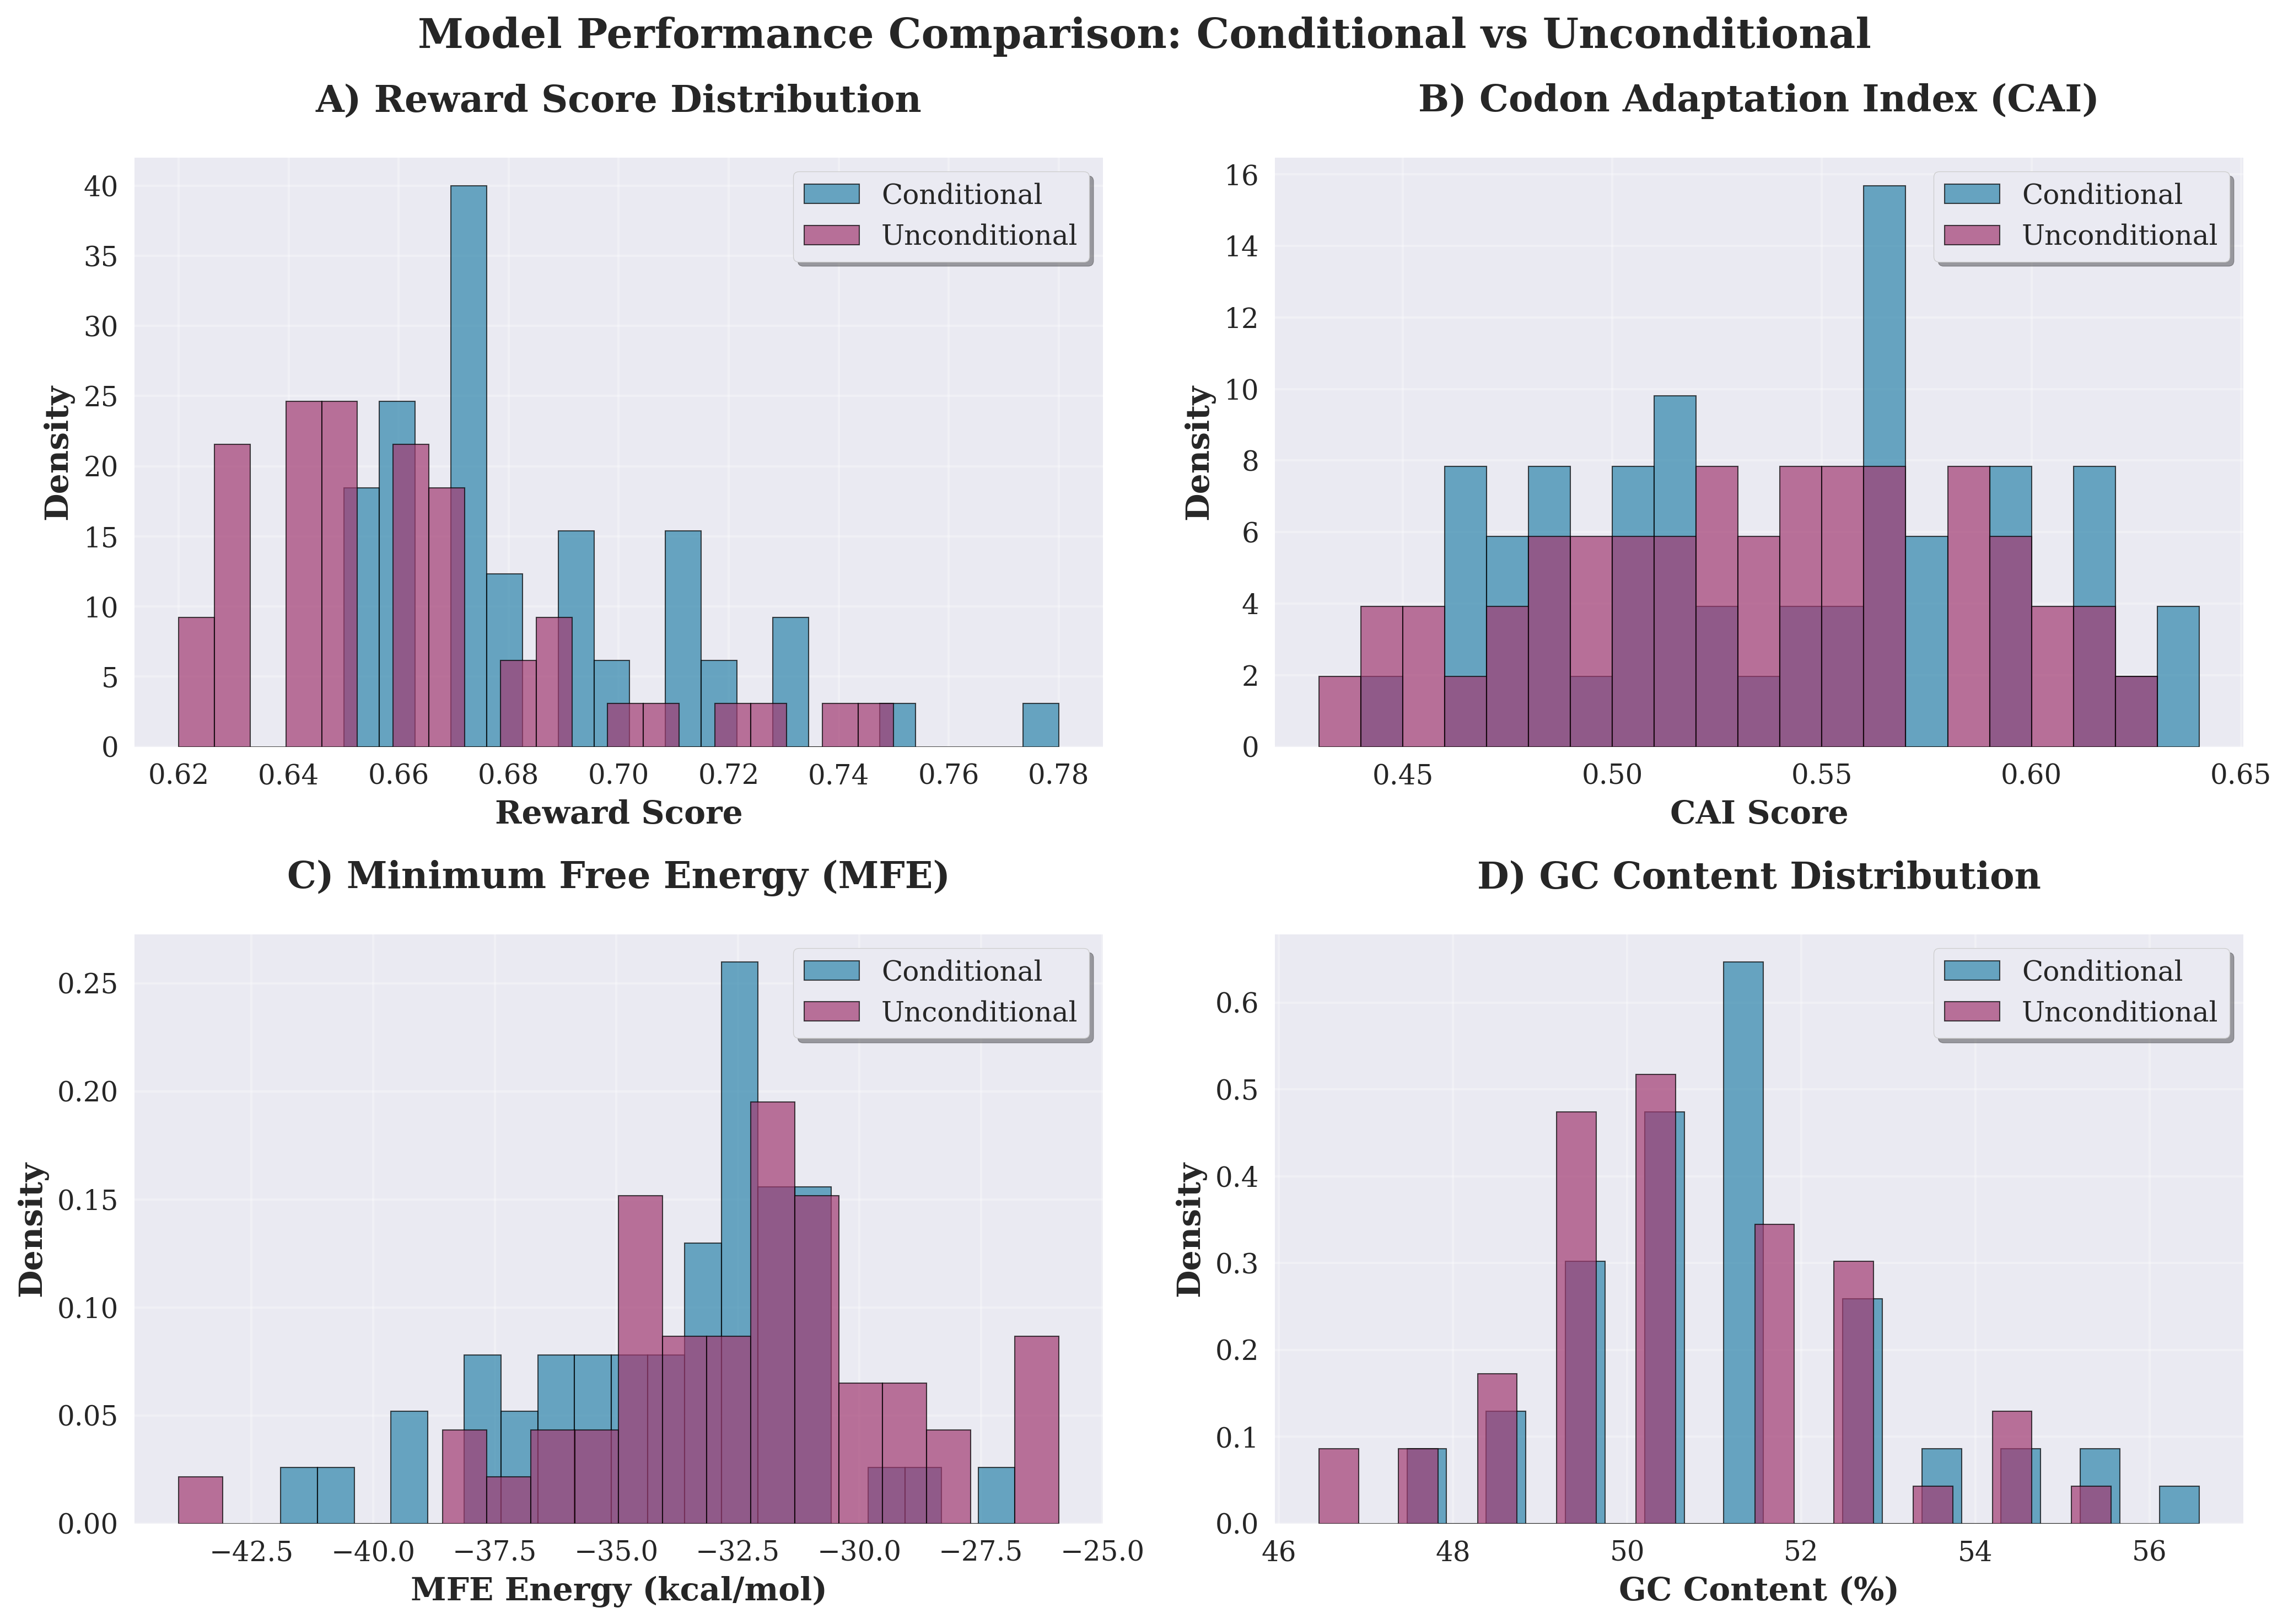

In [50]:
# Figure 1: Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison: Conditional vs Unconditional', fontsize=18, fontweight='bold', y=0.98)

# A) Reward Score Distribution
ax1 = axes[0, 0]
ax1.hist(conditional_df['Reward'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['conditional'], label='Conditional', edgecolor='black', linewidth=0.5)
ax1.hist(unconditional_df['Reward'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['unconditional'], label='Unconditional', edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Reward Score', fontweight='bold')
ax1.set_ylabel('Density', fontweight='bold')
ax1.set_title('A) Reward Score Distribution', fontweight='bold', pad=20)
ax1.legend(frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3)

# B) CAI Score Distribution
ax2 = axes[0, 1]
ax2.hist(conditional_df['CAI'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['conditional'], label='Conditional', edgecolor='black', linewidth=0.5)
ax2.hist(unconditional_df['CAI'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['unconditional'], label='Unconditional', edgecolor='black', linewidth=0.5)
ax2.set_xlabel('CAI Score', fontweight='bold')
ax2.set_ylabel('Density', fontweight='bold')
ax2.set_title('B) Codon Adaptation Index (CAI)', fontweight='bold', pad=20)
ax2.legend(frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3)

# C) MFE Energy Distribution
ax3 = axes[1, 0]
ax3.hist(conditional_df['MFE'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['conditional'], label='Conditional', edgecolor='black', linewidth=0.5)
ax3.hist(unconditional_df['MFE'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['unconditional'], label='Unconditional', edgecolor='black', linewidth=0.5)
ax3.set_xlabel('MFE Energy (kcal/mol)', fontweight='bold')
ax3.set_ylabel('Density', fontweight='bold')
ax3.set_title('C) Minimum Free Energy (MFE)', fontweight='bold', pad=20)
ax3.legend(frameon=True, fancybox=True, shadow=True)
ax3.grid(True, alpha=0.3)

# D) GC Content Distribution
ax4 = axes[1, 1]
ax4.hist(conditional_df['GC_Percent'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['conditional'], label='Conditional', edgecolor='black', linewidth=0.5)
ax4.hist(unconditional_df['GC_Percent'].dropna(), bins=20, alpha=0.7, density=True,
         color=colors['unconditional'], label='Unconditional', edgecolor='black', linewidth=0.5)
ax4.set_xlabel('GC Content (%)', fontweight='bold')
ax4.set_ylabel('Density', fontweight='bold')
ax4.set_title('D) GC Content Distribution', fontweight='bold', pad=20)
ax4.legend(frameon=True, fancybox=True, shadow=True)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/ubuntu/aya/GFN_for_mRNA_design/Figure1_Model_Performance_Comparison.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [48]:
# # Figure 2: Sequence Diversity Analysis (Compact)
# # A) Normalized Levenshtein Distribution
# # Fix: Ensure ax1 is defined, use consistent binning, and clarify labels
# fig, ax1 = plt.subplots(figsize=(10, 6))  # Reduced from (18, 15) to (10, 6)

# # Compute common bin edges for both datasets for fair comparison
# lev_cond = condi_small_df['Levenshtein'].dropna()
# lev_cl = cl_small_df['Levenshtein'].dropna()
# all_lev = pd.concat([lev_cond, lev_cl])
# bins = np.histogram_bin_edges(all_lev, bins=15)  # Reduced bins from 20 to 15

# # Plot histograms with consistent bins and clear labels
# ax1.hist(lev_cond, bins=bins, alpha=0.7, density=True,
#          color=colors['conditional'], label='Conditional', edgecolor='black', linewidth=0.5)
# ax1.hist(cl_small_df['Levenshtein'].dropna(), bins=bins, alpha=0.7, density=True,
#          color=colors['unconditional'], label='Curriculum-Augmented', edgecolor='black', linewidth=0.5)
# ax1.set_xlabel('Levenshtein Distance', fontweight='bold', fontsize=12)
# ax1.set_ylabel('Density', fontweight='bold', fontsize=12)
# ax1.set_title('A) Levenshtein Distance Distribution', fontweight='bold', pad=15, fontsize=14)
# ax1.legend(frameon=True, fancybox=True, shadow=True, fontsize=10)
# ax1.grid(True, alpha=0.2)
# ax1.tick_params(axis='both', which='major', labelsize=10)  # Added smaller tick labels

In [54]:
# # Figure 2: Sequence Diversity Analysis
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# fig.suptitle('Sequence Diversity Analysis: Levenshtein Distance', fontsize=18, fontweight='bold', y=0.98)

# # A) Normalized Levenshtein Distribution
# ax1 = axes[0, 0]
# ax1.hist(conditional_df['Levenshtein'].dropna(), bins=20, alpha=0.7, density=True,
#          color=colors['conditional'], label='Conditional', edgecolor='black', linewidth=0.5)
# ax1.hist(unconditional_df['Levenshtein'].dropna(), bins=20, alpha=0.7, density=True,
#          color=colors['unconditional'], label='Unconditional', edgecolor='black', linewidth=0.5)
# ax1.set_xlabel('Levenshtein Distance', fontweight='bold')
# ax1.set_ylabel('Density', fontweight='bold')
# ax1.set_title('A) Levenshtein Distance Distribution', fontweight='bold', pad=20)
# ax1.legend(frameon=True, fancybox=True, shadow=True)
# ax1.grid(True, alpha=0.3)

# # B) Box Plot Comparison
# ax2 = axes[0, 1]
# data_for_box = [conditional_df['Levenshtein'].dropna(),
#                 unconditional_df['Levenshtein'].dropna()]
# bp = ax2.boxplot(data_for_box, labels=['Conditional', 'Unconditional'], patch_artist=True)
# bp['boxes'][0].set_facecolor(colors['conditional'])
# bp['boxes'][1].set_facecolor(colors['unconditional'])
# bp['boxes'][0].set_alpha(0.7)
# bp['boxes'][1].set_alpha(0.7)
# ax2.set_ylabel('Normalized Edit Distance', fontweight='bold')
# ax2.set_title('B) Diversity Comparison', fontweight='bold', pad=20)
# ax2.grid(True, alpha=0.3)

# # C) Diversity vs Performance
# ax3 = axes[1, 0]
# scatter1 = ax3.scatter(conditional_df['Levenshtein'], conditional_df['Reward'],
#                        alpha=0.6, color=colors['conditional'], label='Conditional', s=50, edgecolors='black', linewidth=0.5)
# scatter2 = ax3.scatter(unconditional_df['Levenshtein'], unconditional_df['Reward'],
#                        alpha=0.6, color=colors['unconditional'], label='Unconditional', s=50, edgecolors='black', linewidth=0.5)
# ax3.set_xlabel('Levenshtein Distance', fontweight='bold')
# ax3.set_ylabel('Reward Score', fontweight='bold')
# ax3.set_title('C) Diversity vs Performance Trade-off', fontweight='bold', pad=20)
# ax3.legend(frameon=True, fancybox=True, shadow=True)
# ax3.grid(True, alpha=0.3)

# # D) Identity Percentage Distribution
# ax4 = axes[1, 1]
# ax4.hist(conditional_df['Identity_Percent'].dropna(), bins=20, alpha=0.7, density=True,
#          color=colors['conditional'], label='Conditional', edgecolor='black', linewidth=0.5)
# ax4.hist(unconditional_df['Identity_Percent'].dropna(), bins=20, alpha=0.7, density=True,
#          color=colors['unconditional'], label='Unconditional', edgecolor='black', linewidth=0.5)
# ax4.set_xlabel('Identity Percentage (%)', fontweight='bold')
# ax4.set_ylabel('Density', fontweight='bold')
# ax4.set_title('D) Sequence Identity Distribution', fontweight='bold', pad=20)
# ax4.legend(frameon=True, fancybox=True, shadow=True)
# ax4.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.savefig('/home/ubuntu/aya/GFN_for_mRNA_design/Figure2_Sequence_Diversity_Analysis.png',
#             dpi=300, bbox_inches='tight', facecolor='white')
# plt.show()

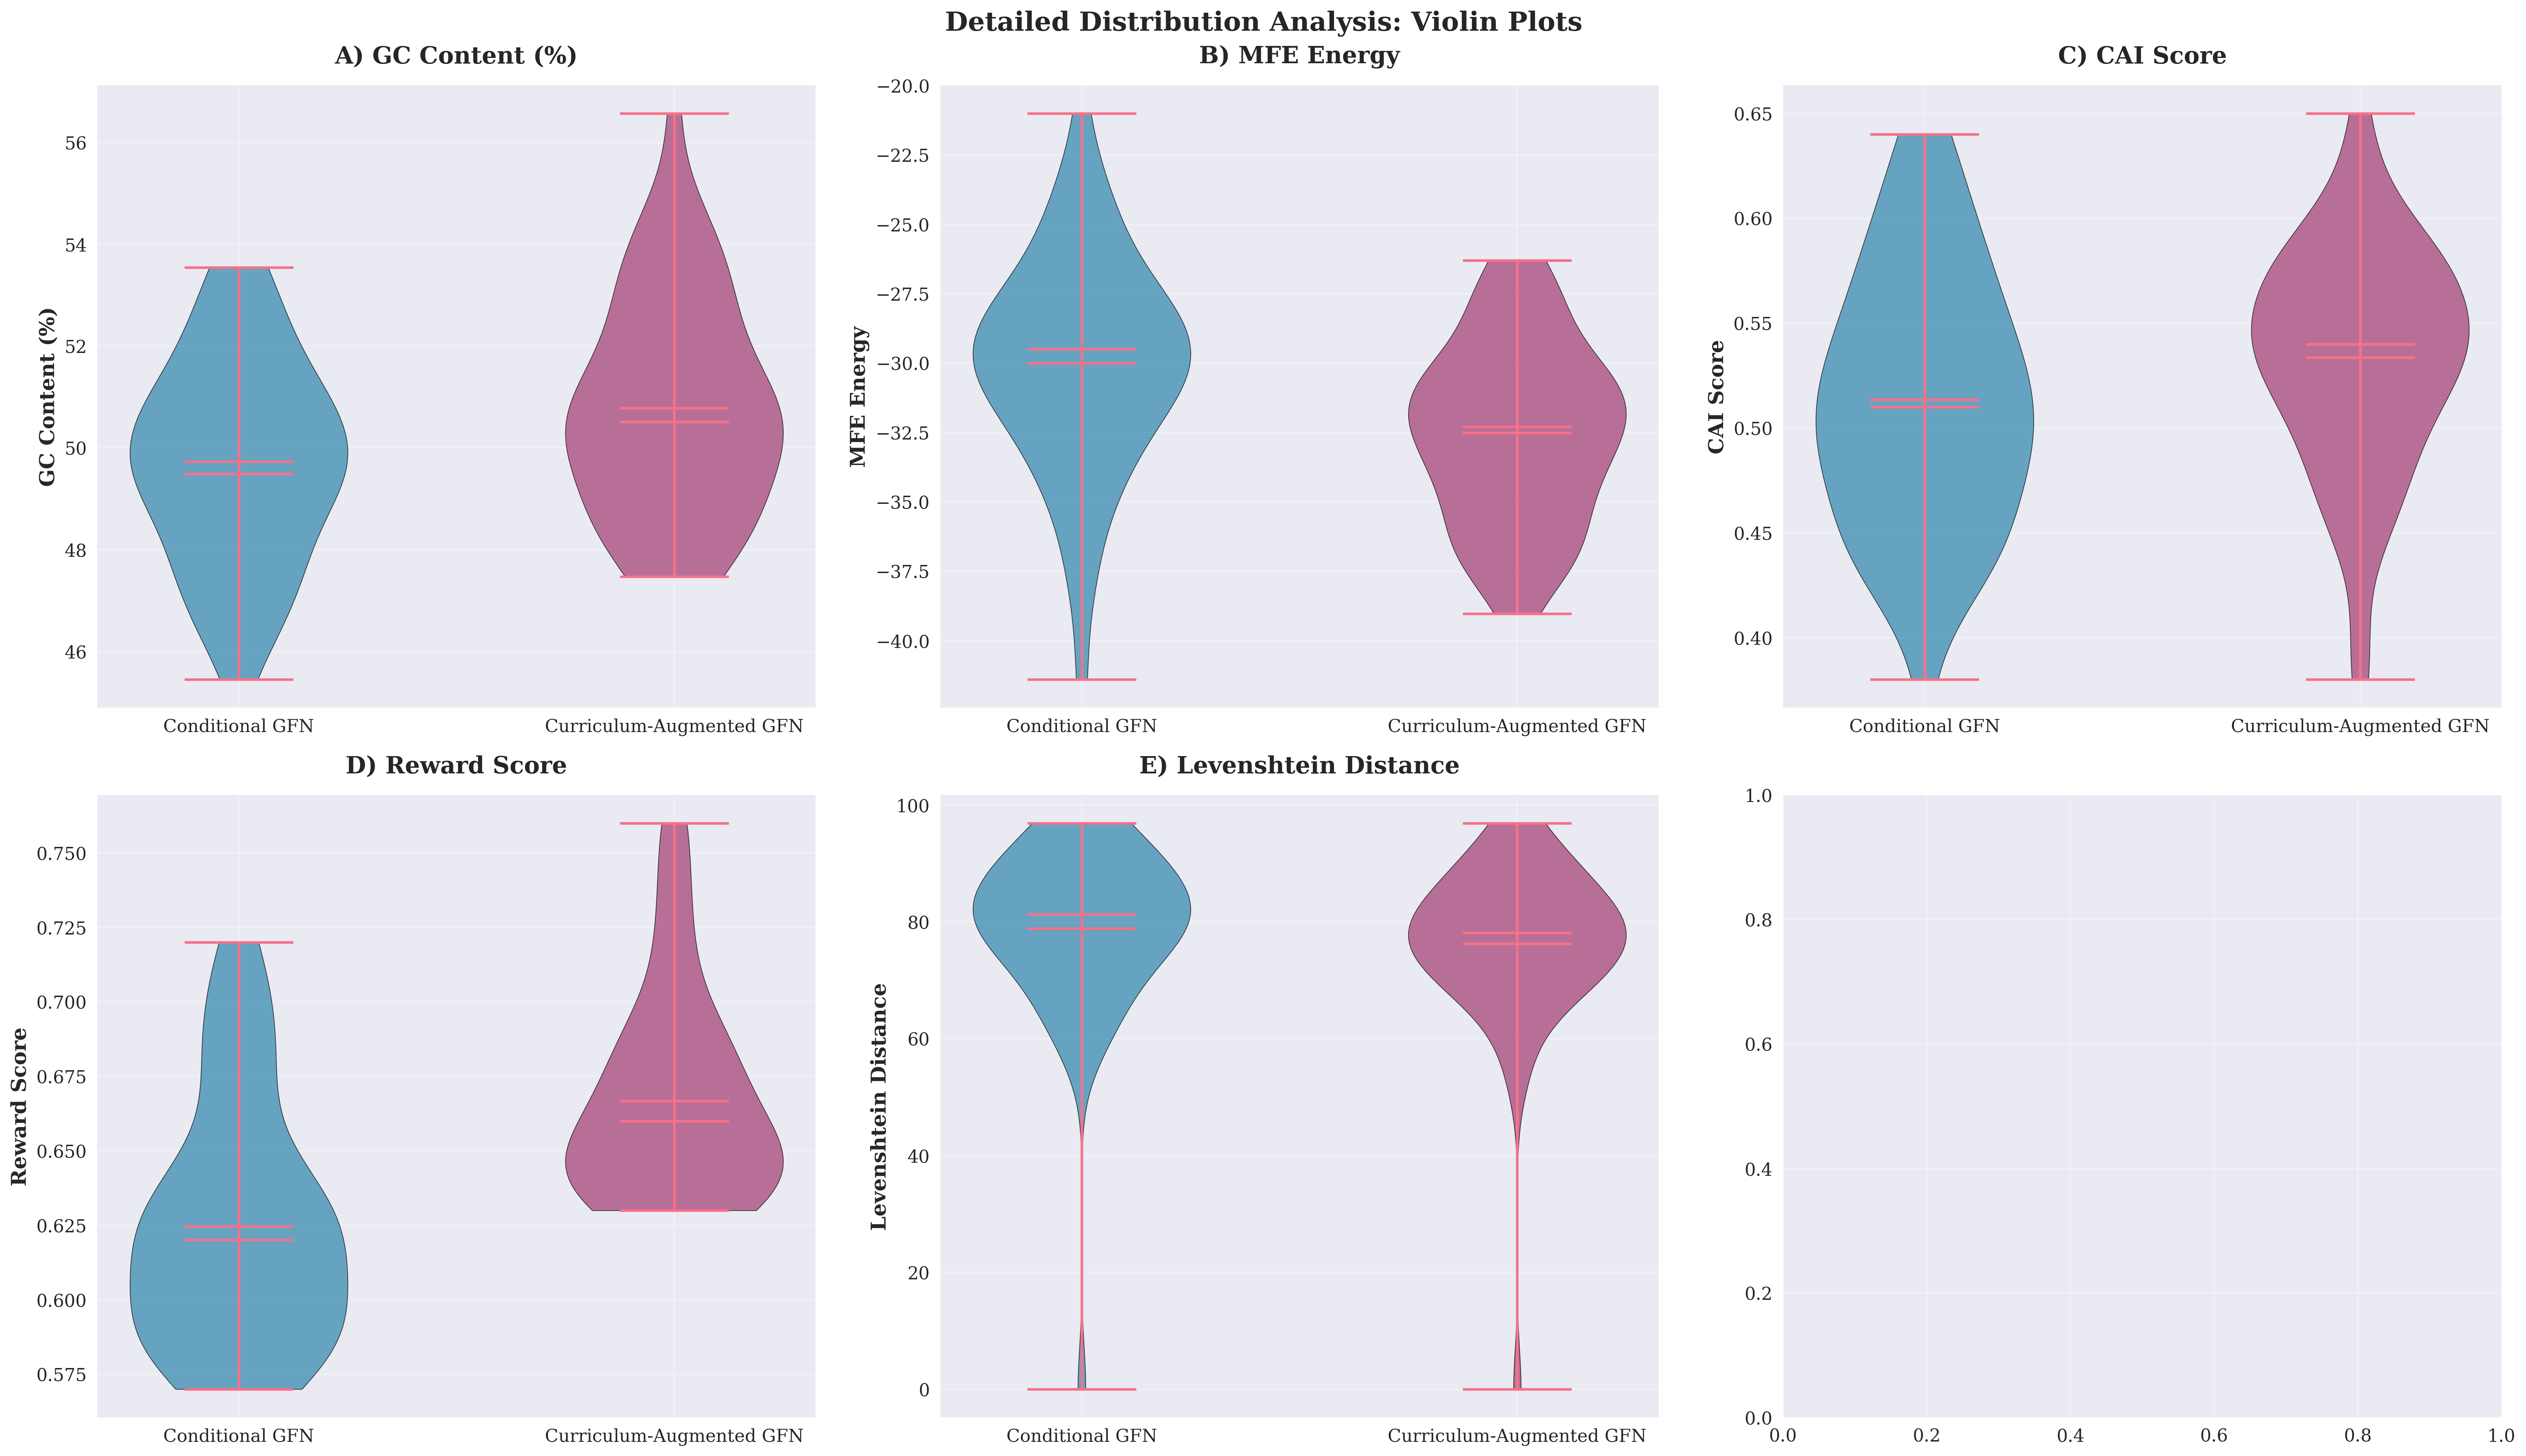

In [55]:
# Figure 5: Violin Plots for Detailed Distribution Analysis
fig, axes = plt.subplots(2, 3, figsize=(24, 14))
fig.suptitle('Detailed Distribution Analysis: Violin Plots', fontsize=18, fontweight='bold', y=0.98)

# Define metrics for violin plots
violin_metrics = ['GC_Percent', 'MFE', 'CAI', 'Reward', 'Levenshtein']
violin_labels = ['GC Content (%)', 'MFE Energy', 'CAI Score', 'Reward Score', 'Levenshtein Distance']

for idx, (metric, label) in enumerate(zip(violin_metrics, violin_labels)):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    # Prepare data for violin plot
    cond_data = condi_small_df[metric].dropna()
    cl_data = cl_small_df[metric].dropna()

    # Create violin plot
    parts = ax.violinplot([cond_data, cl_data], positions=[1, 2],
                          showmeans=True, showmedians=True, showextrema=True)

    # Customize violin plots
    parts['bodies'][0].set_facecolor(colors['conditional'])
    parts['bodies'][0].set_alpha(0.7)
    parts['bodies'][1].set_facecolor(colors['unconditional'])
    parts['bodies'][1].set_alpha(0.7)

    # Customize other elements
    for pc in parts['bodies']:
        pc.set_edgecolor('black')
        pc.set_linewidth(0.5)

    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Conditional GFN', 'Curriculum-Augmented GFN'])
    ax.set_ylabel(label, fontweight='bold')
    ax.set_title(f'{chr(65 + idx)}) {label}', fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/home/ubuntu/aya/GFN_for_mRNA_design/Figure5_Violin_Plots_Distribution_Analysis_Condi_vs_CL.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

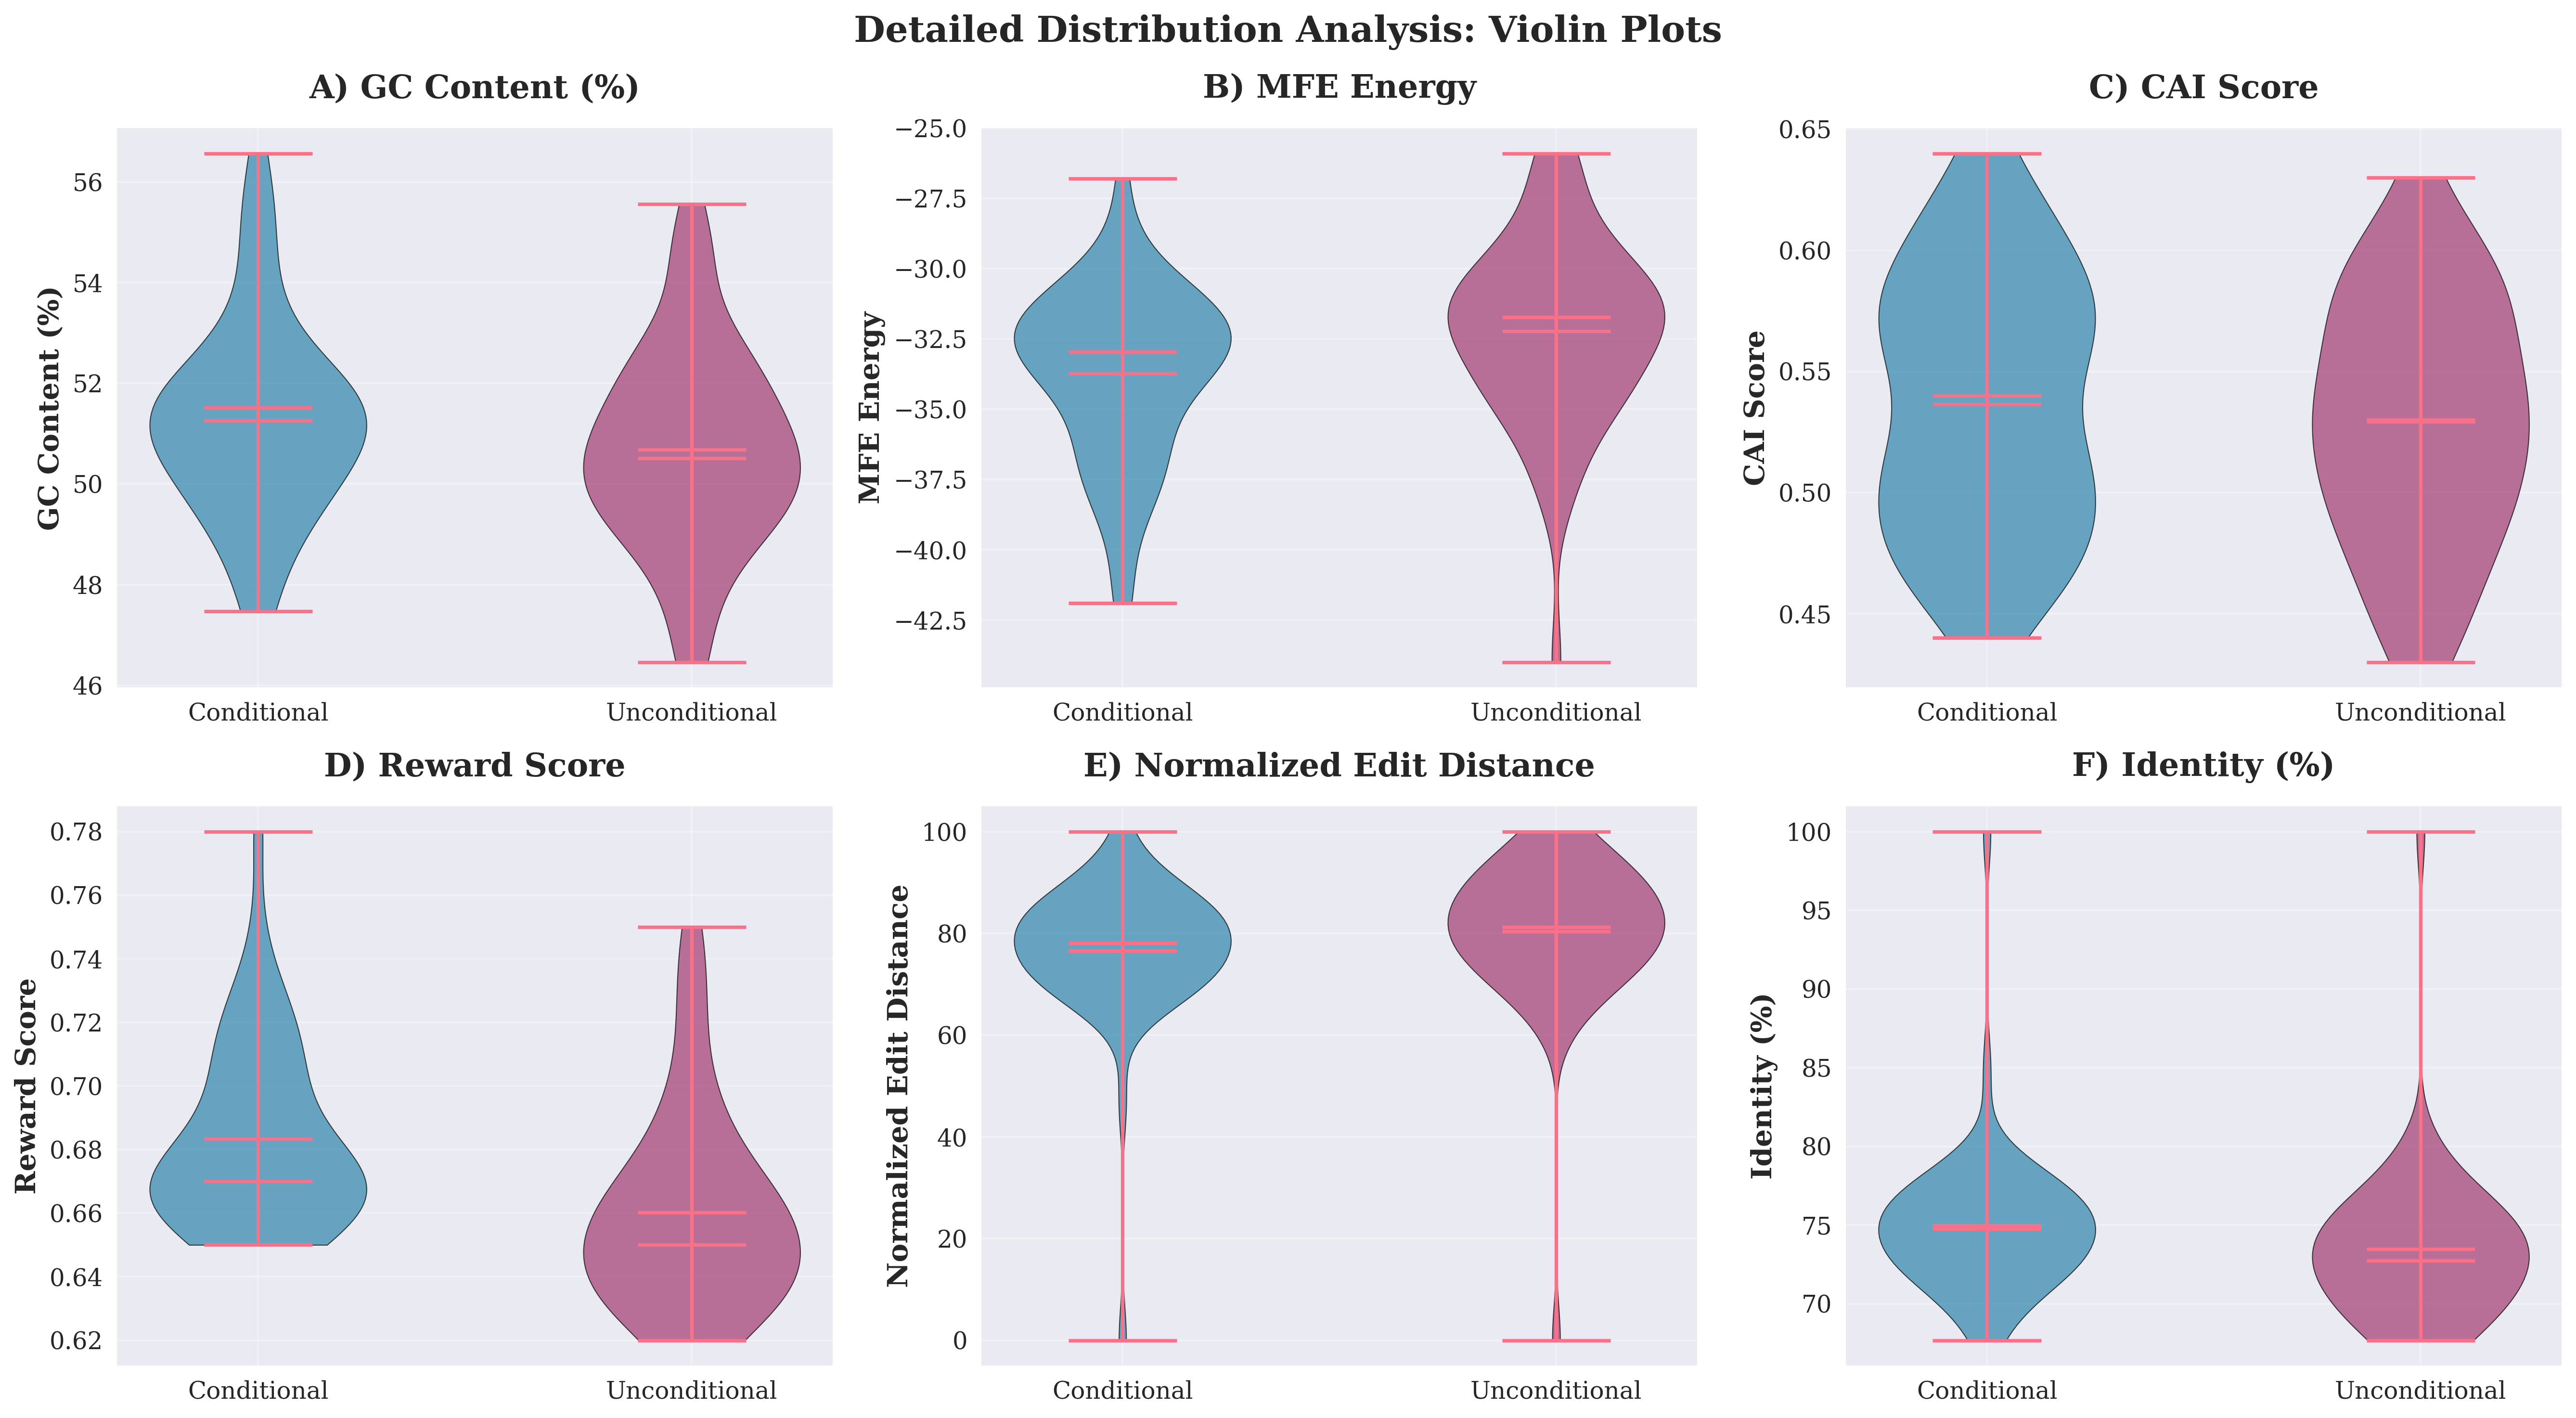

In [ ]:
# Figure 5: Violin Plots for Detailed Distribution Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Detailed Distribution Analysis: Violin Plots', fontsize=18, fontweight='bold', y=0.98)

# Define metrics for violin plots
violin_metrics = ['GC_Percent', 'MFE', 'CAI', 'Reward', 'Levenshtein', 'Identity_Percent']
violin_labels = ['GC Content (%)', 'MFE Energy', 'CAI Score', 'Reward Score', 'Normalized Edit Distance', 'Identity (%)']

for idx, (metric, label) in enumerate(zip(violin_metrics, violin_labels)):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    # Prepare data for violin plot
    cond_data = conditional_df[metric].dropna()
    uncond_data = unconditional_df[metric].dropna()

    # Create violin plot
    parts = ax.violinplot([cond_data, uncond_data], positions=[1, 2],
                          showmeans=True, showmedians=True, showextrema=True)

    # Customize violin plots
    parts['bodies'][0].set_facecolor(colors['conditional'])
    parts['bodies'][0].set_alpha(0.7)
    parts['bodies'][1].set_facecolor(colors['unconditional'])
    parts['bodies'][1].set_alpha(0.7)

    # Customize other elements
    for pc in parts['bodies']:
        pc.set_edgecolor('black')
        pc.set_linewidth(0.5)

    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Conditional', 'Unconditional'])
    ax.set_ylabel(label, fontweight='bold')
    ax.set_title(f'{chr(65 + idx)}) {label}', fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/home/ubuntu/aya/GFN_for_mRNA_design/Figure5_Violin_Plots_Distribution_Analysis.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [50]:
from MFE_calculator import test_graph
from draw_rna import ipynb_draw

In [53]:
rna = "AUGAUCAAUACGCAAGACAGUAGCAUUUUGCCGCUGAGCAACUGUCCACAGCUCCAGUGCUGUAGGCAUAUAGUUCCUGGGCCGCUGUGGUGUAGUUAA"

0         1         2         3         4         5         6         7         8         9         
012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678
AUGAUCAAUACGCAAGACAGUAGCAUUUUGCCGCUGAGCAACUGUCCACAGCUCCAGUGCUGUAGGCAUAUAGUUCCUGGGCCGCUGUGGUGUAGUUAA
.((((...(((((..(((((((((........))).....))))))(((((((((((.((((((....))))))..)))))..))))))))))))))).
Free energy:    -41.4


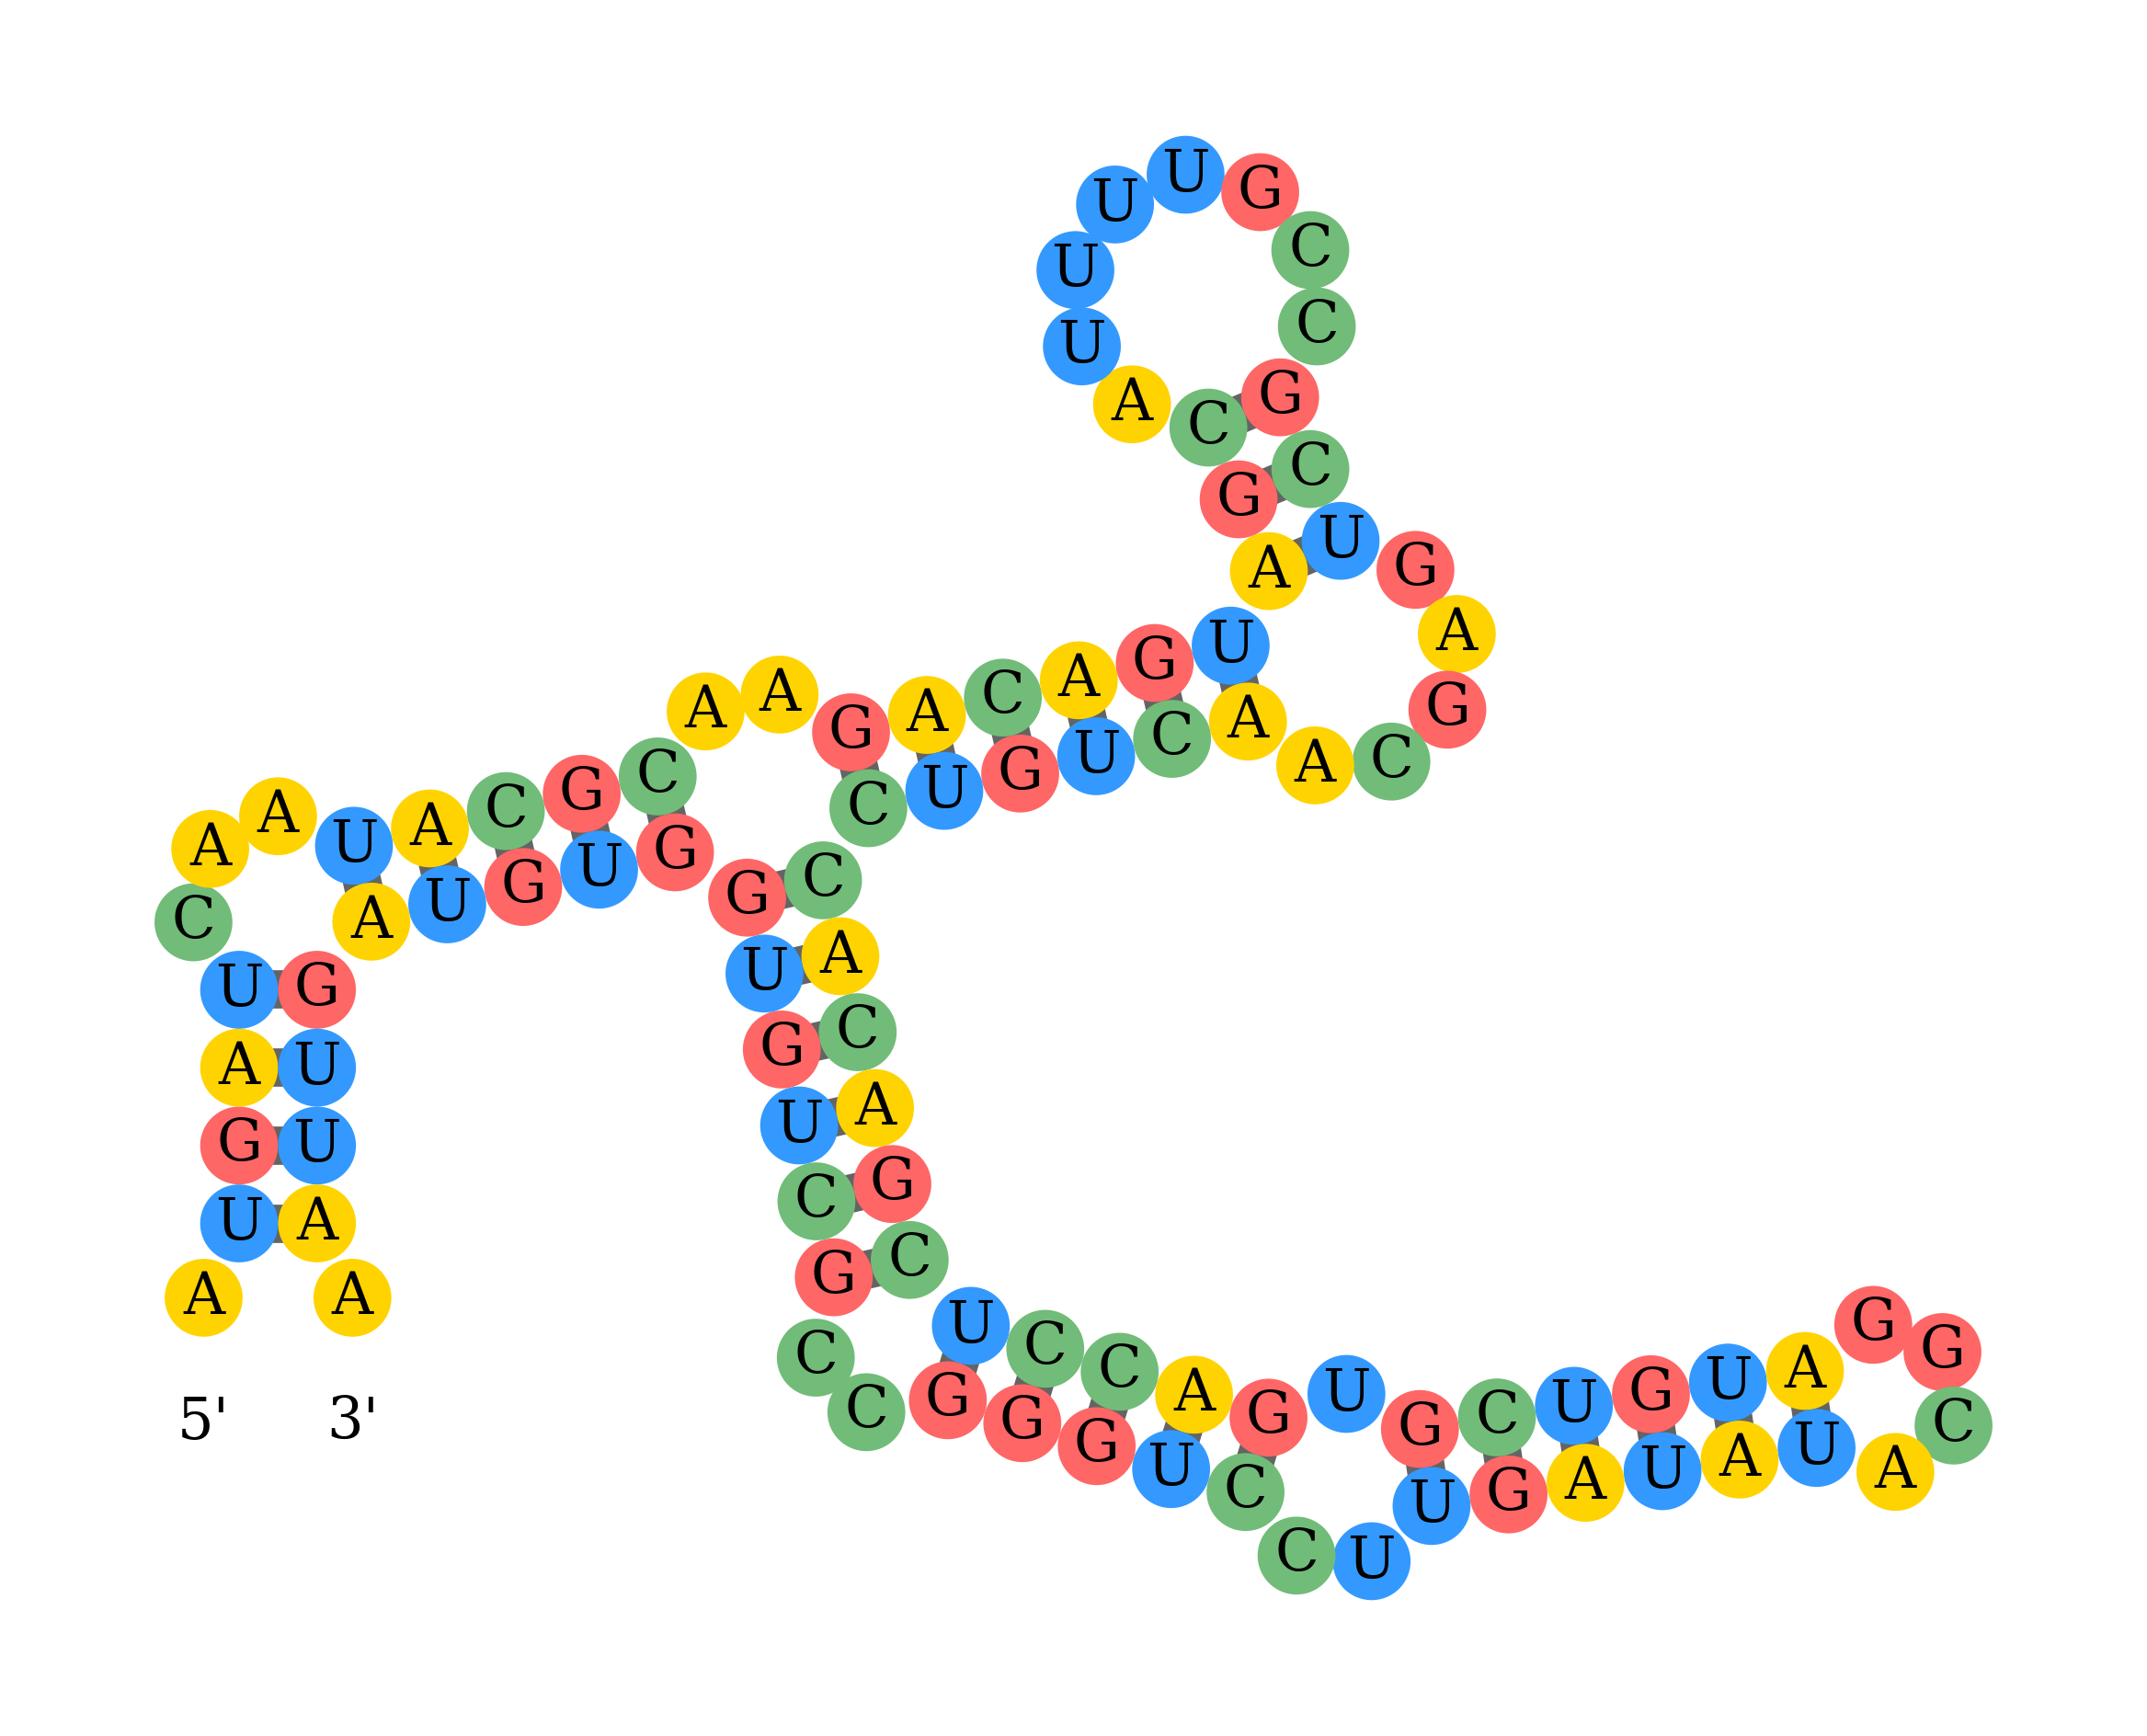

In [54]:
test_graph(rna)